In [11]:
# === IMF Monte Carlo Fit (Dipole) + Proton Charge Radius + Clean Plot ===
import numpy as np
import pandas as pd
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count

In [12]:
df=pd.read_excel("/content/Global_ep_Crosssection_with_Poly5_Rational11_SigleDipole_Sum3Dipole_FromFactor.xlsx")

In [13]:
df['G_E normsys [%]'] = (0.5 * (
    df['G_E_fit_poly5'] * df['eps'] +
    (df['tau'] * df['G_M_fit_poly5']**2) / df['G_E_fit_poly5']
) * (df['normsys [%]']))/df['G_E_fit_poly5']

In [14]:
df=df[(df['G_E_fit_poly5']>0) & (df['G_E_fit_poly5']<1)]

In [15]:
df.columns

Index(['Unnamed: 0', 'Q2 [GeV^2]', 'E0 [GeV]', 'Ep [GeV]', 'theta [deg]',
       'eps', 'sig [nb/sr]', 'dsig number [nb/sr]', 'expt.', 'normsys [%]',
       'First Author', 'theta_rad', 'tau', 'sigma_Mott', 'sigma_R',
       'delta_sigma_R', 'G_E_fit_rational_11', 'G_M_fit_rational_11',
       'G_E_fit_poly5', 'G_M_fit_poly5', 'delta_G_E_poly5', 'G_E_fit_dipole',
       'G_M_fit_dipole', 'delta_G_E_dipole', 'G_E_fit_sum3', 'G_M_fit_sum3',
       'delta_G_E_sum3', 'delta_G_E_rational_11', 'G_E normsys [%]'],
      dtype='object')

Iter 1: 300/300 good fits, Δ=1.37e-02
 mean: [0.98316144 0.71038437]
Iter 2: 300/300 good fits, Δ=2.87e-05
 mean: [0.98319592 0.71037942]
Converged.

Final parameters (mean ± std):
G0 = 9.831959e-01 ± 6.550159e-04
Lambda² = 7.103794e-01 ± 1.432275e-03


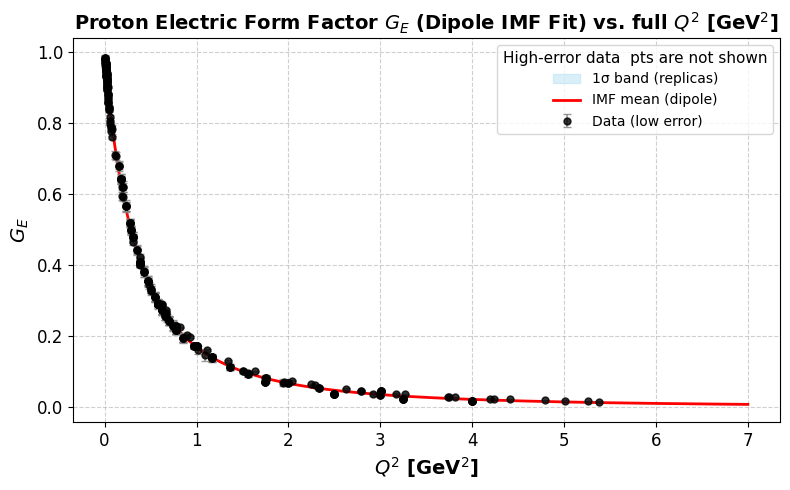

In [16]:
# === Load dataset ===
Q2 = df["Q2 [GeV^2]"].to_numpy()
GE = df["G_E_fit_dipole"].to_numpy()          # you can replace with any G_E data
GE_err = df["delta_G_E_dipole"].abs().to_numpy()
normsys = df["G_E normsys [%]"].to_numpy() / 100.0  # convert % to fraction

# === Dipole function ===
def dipole(Q2, G0, Lambda2):
    return G0 / (1 + Q2 / Lambda2)**2

# === Build IMF covariance ===
def build_covIMF(errs, model_vals, deltan):
    cov = np.diag(errs**2)
    return cov + (deltan**2) * np.outer(model_vals, model_vals)

# === Replica generation ===
def generate_replica(y, errs, deltan):
    yR = y + np.random.normal(scale=errs)
    nR = np.random.normal(1.0, deltan)
    return nR * yR

# === Residuals ===
def residuals(params, Q2, y_rep, covIMF_inv_sqrt):
    y_pred = dipole(Q2, *params)
    return covIMF_inv_sqrt @ (y_rep - y_pred)

# === Bounded fit for multiprocessing ===
def fit_one_bounded(args):
    Q2, y_rep, covIMF_inv_sqrt, p0, bounds = args
    try:
        res = least_squares(
            residuals, p0, args=(Q2, y_rep, covIMF_inv_sqrt),
            bounds=bounds, max_nfev=2000
        )
        return res.x
    except Exception:
        return np.full(2, np.nan)

# === Stable IMF iteration ===
def IMF_dipole(Q2, y, yerr, deltan, R=200, n_iter=6, tol=1e-4, n_cpu=None):
    if n_cpu is None:
        n_cpu = max(1, cpu_count() - 1)
    p_hat = np.array([1.0, 0.71])  # initial guess: G0=1, Lambda2=0.71 GeV²
    prev_mean = p_hat.copy()
    bounds = ([0.5, 0.1], [1.5, 2.0])  # reasonable physical limits

    for iteration in range(n_iter):
        Mhat = np.clip(dipole(Q2, *p_hat), -2, 2)
        covIMF = build_covIMF(yerr, Mhat, deltan.mean()) + 1e-10 * np.eye(len(Q2))
        vals, vecs = np.linalg.eigh(covIMF)
        vals[vals < 1e-15] = 1e-15
        covIMF_inv_sqrt = vecs @ np.diag(1.0 / np.sqrt(vals)) @ vecs.T

        args_list = [(Q2, generate_replica(y, yerr, deltan.mean()), covIMF_inv_sqrt, p_hat, bounds)
                     for _ in range(R)]

        with Pool(processes=n_cpu) as pool:
            all_params = np.array(pool.map(fit_one_bounded, args_list))

        mask = ~np.isnan(all_params).any(axis=1)
        if mask.sum() == 0:
            print(f"Iter {iteration+1}: all fits failed — aborting.")
            break

        params_mean = all_params[mask].mean(axis=0)
        params_std = all_params[mask].std(axis=0, ddof=1)
        rel_change = np.linalg.norm(params_mean - prev_mean) / (np.linalg.norm(prev_mean) + 1e-12)

        print(f"Iter {iteration+1}: {mask.sum()}/{R} good fits, Δ={rel_change:.2e}")
        print(" mean:", params_mean)

        p_hat = params_mean.copy()
        if rel_change < tol:
            print("Converged.")
            break
        prev_mean = params_mean.copy()

    return params_mean, params_std, all_params[mask]

# === Run IMF fit ===
params_mean, params_std, params_reps = IMF_dipole(Q2, GE, GE_err, normsys, R=300, n_iter=6, tol=5e-4)

print("\nFinal parameters (mean ± std):")
print(f"G0 = {params_mean[0]:.6e} ± {params_std[0]:.6e}")
print(f"Lambda² = {params_mean[1]:.6e} ± {params_std[1]:.6e}")


# === Prepare plot data ===
Q2_plot = np.linspace(Q2.min(), Q2.max(), 200)
GE_mean = dipole(Q2_plot, *params_mean)
GE_samples = np.array([dipole(Q2_plot, *p) for p in params_reps])
GE_low = np.percentile(GE_samples, 16, axis=0)
GE_high = np.percentile(GE_samples, 84, axis=0)

# --- Mask for low-error data (relative error < 20%) ---
rel_err = GE_err / np.abs(GE)
mask_plot = rel_err < 0.2

# === Plot ===
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.title("Proton Electric Form Factor $G_E$ (Dipole IMF Fit) vs. full $Q^2$ [GeV$^2$]",
          fontsize=14, fontweight='bold')

# --- 1σ band ---
plt.fill_between(Q2_plot, GE_low, GE_high, color='skyblue', alpha=0.3, label="1σ band (replicas)")

# --- IMF mean curve ---
plt.plot(Q2_plot, GE_mean, 'r-', lw=2, label="IMF mean (dipole)")

# --- Data points with error bars ---
plt.errorbar(Q2[mask_plot], GE[mask_plot], yerr=GE_err[mask_plot],
             fmt='o', markersize=5, color='k', ecolor='gray', elinewidth=1.2, capsize=3,
             alpha=0.8, label="Data (low error)")

# --- Grid ---
plt.grid(True, linestyle='--', alpha=0.6)

# --- Labels ---
plt.xlabel(r"$Q^2$ [GeV$^2$]", fontsize=14, fontweight='bold')
plt.ylabel(r"$G_E$", fontsize=14, fontweight='bold')

# --- Tick styling ---
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# --- Legend ---

plt.legend(title=f"High-error data  pts are not shown",
           fontsize=10, title_fontsize=11, loc="best")

# --- Layout ---
plt.tight_layout()
plt.show()

In [17]:
hbarc = 0.1973269804
r_list = []
for p in params_reps:
    G0_r, L_r = p[0], p[1]   # G0_r included but not used
    if L_r > 0:
        r_list.append(np.sqrt(12.0 / L_r) * hbarc)

r_arr = np.array(r_list)
r_mean = r_arr.mean()
r_std  = r_arr.std(ddof=1)
print(f"r_E = {r_mean:.5f} ± {r_std:.5f} fm (replica-based)")


r_E = 0.81102 ± 0.00082 fm (replica-based)


Combined G_E uncertainty (first 5):
[0.00404609 0.00334516 0.00272468 0.003546   0.00237583]
Chi-squared (χ²) = 2988.785
Degrees of freedom (ndf) = 303
Reduced chi-squared (χ²/ndf) = 9.864


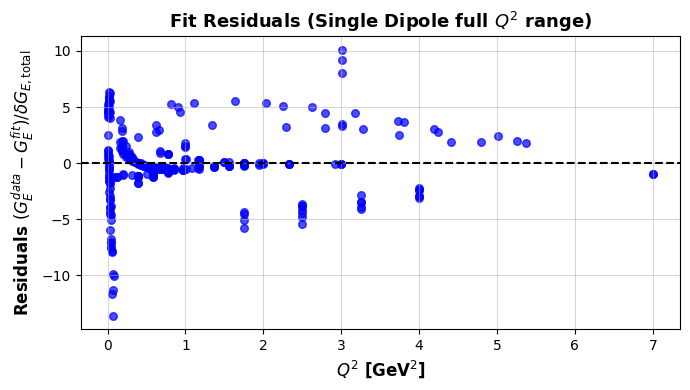

In [18]:
# === Goodness of Fit (Chi-squared) ===

# Predicted G_E values from the fitted model
GE_pred = dipole(Q2, *params_mean)
# === Combine statistical and normalization uncertainties ===

G_err = np.sqrt(GE_err**2 + (GE * normsys)**2)

# Optional: check first few values
print("Combined G_E uncertainty (first 5):")
print(G_err[:5])

# Chi-squared numerator
chi2 = np.sum(((GE - GE_pred) / GE_err) ** 2)

# Degrees of freedom = number of data points - number of parameters
ndf = len(GE) - len(params_mean)

# Reduced chi-squared
chi2_reduced = chi2 / ndf

print(f"Chi-squared (χ²) = {chi2:.3f}")
print(f"Degrees of freedom (ndf) = {ndf}")
print(f"Reduced chi-squared (χ²/ndf) = {chi2_reduced:.3f}")

# Optional: visualize residuals
plt.figure(figsize=(7,4))
plt.scatter(Q2, (GE - GE_pred) / GE_err, s=30, c='blue', alpha=0.7)
plt.axhline(0, color='k', linestyle='--')
plt.xlabel(r"$Q^2$ [GeV$^2$]", fontsize=12, fontweight='bold')
plt.ylabel(r"Residuals $(G_E^{data}-G_E^{fit})/\delta G_{E,\rm total}$",
           fontsize=12, fontweight='bold')
plt.title("Fit Residuals (Single Dipole full $Q^2$ range)",
          fontsize=13, fontweight='bold')
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()